In [378]:
# Code to construct basic power grid networks and solve using DC OPF, with specific focus on analysis of 
# Locational Marginal Prices (LMP)
# @author: kyribaker

import cvxpy as cp
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

# DEFINE NETWORK PARAMETERS ````````
nbus = 6 # number of buses
ngen = 5 # number of generators
nline = 6
loads = [0, 0, 0, 264, 0, 0] # by default, a load is at each bus (set to zero if no load)
genbus = [0, 1, 2, 4, 5] # bus locations of generators - remember Python is zero-indexed...
gencost = [45, 0, 42, 40, 0] # cost of each generator
genlim_down = [0]*ngen # lower generation limits
genlim_up = [100, 60, 50, 100, 60] # upper generation limits

# adjacency matrix - 0 if nodes i and j are not connected, 1 if they are.
Ao = np.zeros((nbus,nbus))

# # 6 node example from Pritchard: A Single-Settlement, Energy-Only Electric Power Market
#for Unpredictable and Intermittent Participants
Ao[0,1] = 1;
Ao[1,2] = 1;
Ao[2,3] = 1; 
Ao[3,4] = 1; 
Ao[4,5] = 1; 
Ao[0,5] = 1;

A = np.maximum(Ao, Ao.transpose())

assert sum(sum(A)) == nline*2, "Did you form the Adjacency matrix correctly?"
assert sum(np.diag(A)) == 0, "Did you form the Adjacency matrix correctly?"

# DEFINE CVXPY VARIABLES ````````
Pg = cp.Variable(ngen)
t = cp.Variable(nbus)

# line susceptance matrix
B = A

# line limits : 12345 indicates no flow limit
L = 12345*np.ones((nbus, nbus))
L[3,4] = 150; L[4,3] = 150

In [379]:
obj = 0
for i in range(ngen):
    obj += gencost[i]*Pg[i]
    
objective = cp.Minimize(obj)
constraints = []
LMP_idx = [] # to store location of power balance constraints
flow_idx = [] # to store location of lineflow constraints

# Generator limits
constraints += [Pg >= genlim_down] # Minimum generation limit
constraints += [Pg <= genlim_up] # Maximum generation limit

# Power Balance and Line flow limits
for i in range(nbus):
    tmpcon = 0
    if i in genbus: 
        tmpcon = -Pg[genbus.index(i)] + loads[i]
    else: 
        tmpcon = loads[i]
    for j in range(nbus):
        tmpcon += B[i,j]*(t[i]-t[j])
        if L[i,j] != 12345: # Line limit exists on this line
            constraints += [B[i,j]*(t[i]-t[j]) <= L[i,j]]
            constraints += [B[i,j]*(t[j]-t[i]) <= L[i,j]]
            flow_idx += [len(constraints)-1]
            flow_idx += [len(constraints)]
    constraints += [tmpcon == 0]
    LMP_idx += [len(constraints)]

prob = cp.Problem(objective, constraints)

results = prob.solve()
print(prob.status)

# Get LMPs from solver
busLMP = [constraints[i-1].dual_value for i in LMP_idx]

# If congestion is present, these multipliers should be > 0
lineLMP = [constraints[i-1].dual_value for i in flow_idx]

print('\n`````````DUAL VARIABLE INFO`````````')

for i in range(nbus):
    print('Price at bus ' + str(i) + ': $' + str(round(busLMP[i],2)))

if sum(lineLMP) > 0.2:
    print('Congestion present!')
else:
    print('No congestion present!')

print('\n`````````GENERATOR INFO`````````')

for i in range(nbus):
    if i in genbus: 
        print('Gen '+ str(i) + ': ' + str(round(Pg[genbus.index(i)].value)) + " MWh, gets paid: $", 
              str(round(Pg[genbus.index(i)].value*busLMP[i],2)))

optimal

`````````DUAL VARIABLE INFO`````````
Price at bus 0: $41.0
Price at bus 1: $41.5
Price at bus 2: $42.0
Price at bus 3: $42.5
Price at bus 4: $40.0
Price at bus 5: $40.5
Congestion present!

`````````GENERATOR INFO`````````
Gen 0: 0 MWh, gets paid: $ 0.0
Gen 1: 60 MWh, gets paid: $ 2490.0
Gen 2: 45 MWh, gets paid: $ 1890.0
Gen 4: 99 MWh, gets paid: $ 3960.0
Gen 5: 60 MWh, gets paid: $ 2430.0


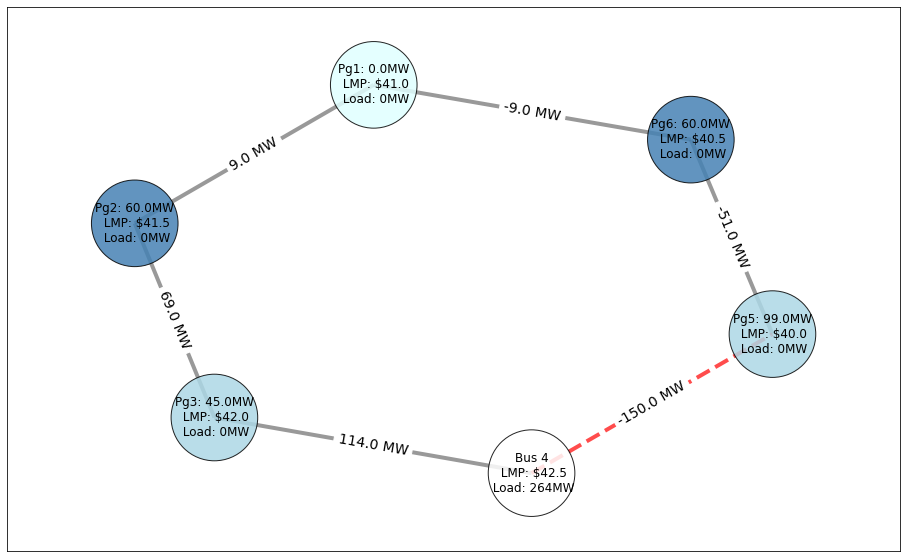

In [391]:
# Plot network
G.clear()
rows, cols = np.where(Ao == 1)
G = nx.Graph()
pos = nx.spring_layout(G, seed=7)

color_map = []
lab = {}
for i in range(nbus):
    if i in genbus:
        #lab[i] = "Pg " + str(i+1)+ ": $" + str(gencost[genbus.index(i)]) 
        lab[i] = "Pg" + str(i+1)+ ": " + str(round(Pg[genbus.index(i)].value, 2)) +"MW" 
        lab[i] += "\n LMP: $" + str(round(busLMP[i],2))
        lab[i] += "\n Load: " + str(loads[i]) + "MW"
        if abs(genlim_up[genbus.index(i)] - Pg[genbus.index(i)].value) < 0.1: # gen at its max
            color_map.append('steelblue')
        elif abs(Pg[genbus.index(i)].value - genlim_down[genbus.index(i)]) < 0.1:
            color_map.append('lightcyan')
        else:
            color_map.append('lightblue')
    else:
        lab[i] = "Bus " + str(i+1)  
        lab[i] += "\n LMP: $" + str(round(busLMP[i],2))
        lab[i] += "\n Load: " + str(loads[i]) + "MW"
        color_map.append('white')

edge_labels = {}
flow = np.zeros((nbus, nbus))
for i in range(nline):
    flow[rows[i], cols[i]] = round(B[rows[i],cols[i]]*(t[rows[i]].value-t[cols[i]].value), 2)
    G.add_edge(rows[i], cols[i])
    edge_labels[rows[i], cols[i]] = str(round(B[rows[i],cols[i]]*(t[rows[i]].value-t[cols[i]].value), 2)) + " MW"
    
fig, ax = plt.subplots(figsize=(16,10))  

elarge = [(u, v) for (u, v) in G.edges() if abs(round(flow[u,v])) >= abs(L[u,v])]
esmall = [(u, v) for (u, v) in G.edges() if abs(round(flow[u,v])) < abs(L[u,v])]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, nodelist = range(nbus), node_size=7500, node_color=color_map, alpha = 0.85)

# edges
#nx.draw_networkx_edges(G, pos, width=3)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=4, alpha=0.4)
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4, alpha=0.7, edge_color="r", style="dashed")

# node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", labels = lab)

# edge weight labels
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=14)

# nx.draw(G, with_labels=True, labels = lab, node_size=4500, node_color = color_map, 
#          edge_color='black', font_color='black')

ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor('black') 
plt.margins(x=0.2, y=0.2)